# Project 5 - Vehicle Detection

## Libraries

In [1]:
%reset -f

In [2]:
import cv2, os, glob, time, random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from lesson_functions import *
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Loading image dataset

In [3]:
cars, notcars = [], []
path = './images_classifier'
images = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(path)
    for f in files if f.endswith('.png')]
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    elif 'vehicles' in image:
        cars.append(image)
print("Cars: ",len(cars), " - Not Cars: ", len(notcars))

Cars:  8792  - Not Cars:  8968


In [4]:
random.shuffle(cars)
random.shuffle(notcars)

In [5]:
def multiplot(img_list, title_list, shape, **kwargs):
    fig = plt.figure(figsize=(15, 15))
    shape_str = str(shape[0])+str(shape[1])
    for ind, img in enumerate(img_list):
        pos = int(shape_str+str(ind+1))
        plt.subplot(pos)
        plt.imshow(img, **kwargs)
        plt.title(title_list[ind])

In [7]:
img_car = mpimg.imread(cars[random.randint(0,len(cars)-1)])
img_car = np.uint8(img_car*255)
img_notcar = mpimg.imread(notcars[random.randint(0,len(notcars)-1)])
img_notcar = np.uint8(img_notcar*255)

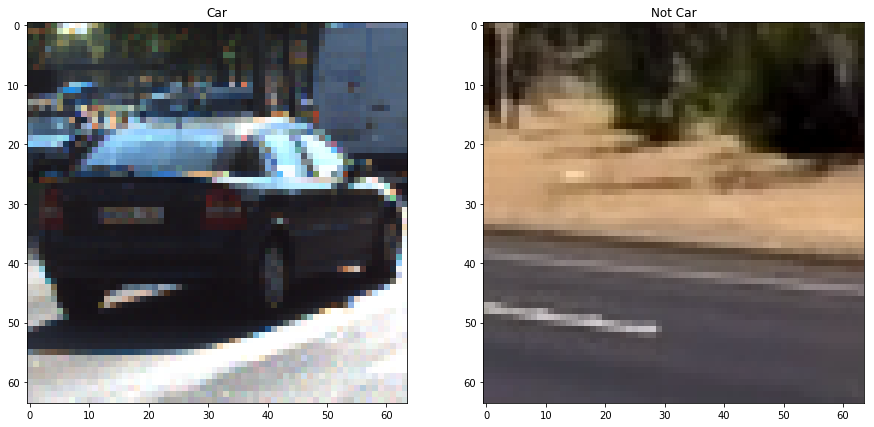

In [8]:
multiplot([img_car, img_notcar], ['Car', 'Not Car'], (1,2))

## Feature extraction

In [6]:
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [7]:
# We adapt the single img feature function to extract visual representations
def single_img_features_images(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    img_features = [img]
    img_names = ['Original']
    feature_image = col_cvt(img, color_space = color_space)
    if spatial_feat == True:
        spatial_features = cv2.resize(feature_image, spatial_size)
        img_features.append(spatial_features)
        img_names.append('Conv + Binning')
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        img_names.append('Color Hist (3chan)')
    if hog_feat == True:
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                img_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=True, feature_vec=True)[1])
                img_names.append('HOG (Channel '+str(channel)+')')
        else:
            img_features.append(get_hog_features(feature_image[:,:,hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)[1])
            img_names.append('HOG (Channel '+str(hog_channel)+')')
    return img_features, img_names

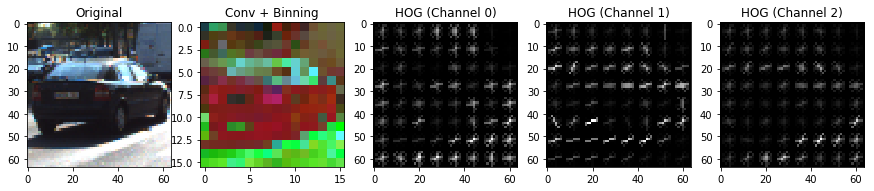

In [13]:
car_img_features, car_img_names = single_img_features_images(img_car, color_space=color_space, spatial_size=spatial_size,
                                            hist_bins=hist_bins, orient=orient,
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                            spatial_feat=spatial_feat, hist_feat=False, hog_feat=hog_feat)
multiplot(car_img_features, car_img_names, (1,len(car_img_names)), cmap = "gray")

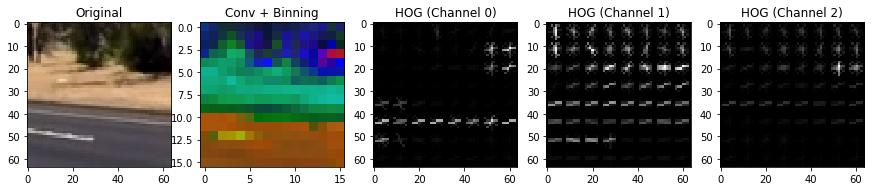

In [14]:
notcar_img_features, car_img_names = single_img_features_images(img_notcar, color_space=color_space, spatial_size=spatial_size,
                                            hist_bins=hist_bins, orient=orient,
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                            spatial_feat=spatial_feat, hist_feat=False, hog_feat=hog_feat)
multiplot(notcar_img_features, car_img_names, (1,len(car_img_names)), cmap = "gray")

In [8]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

(17760, 6108)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


## Classifier fitting

In [9]:
# Use a linear SVC 
initial_svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
parameters = {'C':[0.01, 0.05, 0.1, 0.25, 0.5, 1]}
svc = GridSearchCV(initial_svc, parameters) 
svc.fit(X_train, y_train)
t2 = time.time()

print("Best parameter: ", svc.best_params_)
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Best parameter:  {'C': 0.01}
439.05 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


## Sliding windows definition

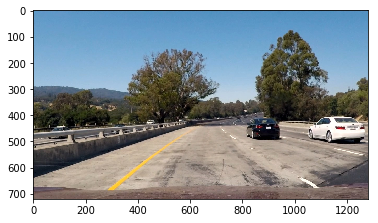

In [11]:
image = mpimg.imread('./test_images/test1.jpg')
plt.imshow(image)

In [12]:
h, w, d = image.shape
x_start_stop_list = [[10, w-10],[10, w-10],[10, w-10],[10, w-10]]
y_start_stop_list = [[380, 620], [380, 560], [395, 515], [405, 475]]
xy_window_list = [(240, 240), (180, 180), (120, 120), (70, 70)]
xy_overlap_list = [(0.75, 0.75),(0.75, 0.75),(0.75, 0.75),(0.75, 0.75)]

In [13]:
def multi_slide_window(img, x_start_stop_list=[[None, None]], y_start_stop_list=[[None, None]],
                 xy_window_list=[(64, 64)], xy_overlap_list=[(0.5, 0.5)]):
    window_list = []
    for ind in range(len(x_start_stop_list)):
        window_it = slide_window(img, x_start_stop=x_start_stop_list[ind], y_start_stop=y_start_stop_list[ind], 
                    xy_window=xy_window_list[ind], xy_overlap=xy_overlap_list[ind])
        window_list += window_it
    return window_list

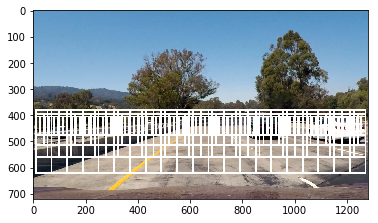

In [14]:
windows = multi_slide_window(image, x_start_stop_list=x_start_stop_list, y_start_stop_list=y_start_stop_list,
                 xy_window_list=xy_window_list, xy_overlap_list=xy_overlap_list)
window_img = draw_boxes(image, windows, color=(255, 255, 255), thick=6) 
plt.imshow(window_img)

In [17]:
t1=time.time()
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)     
t2 = time.time()
print("Time: ", t2-t1, "s")

Time:  1.1956210136413574 s


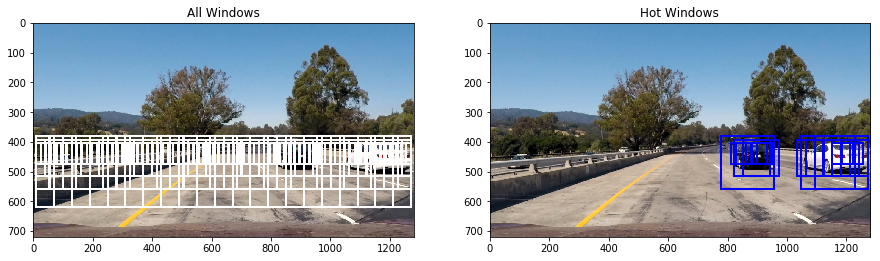

In [18]:
hot_window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
multiplot([window_img, hot_window_img], ['All Windows', 'Hot Windows'], (1,2))

## Adding heat

In [19]:
heat_historical = np.zeros((h,w,5)).astype(np.float)

In [24]:
def add_heat_box(image, hot_windows, threshold = 2):
    
    global heat_historical
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    
    # Smoothing
    kernel = np.ones((10,10),np.float32)/100
    heat = cv2.filter2D(heat,-1,kernel)
    heat = cv2.filter2D(heat,-1,kernel)
    
    if np.amax(heat_historical) == 0:
        heat_historical = np.dstack((heat,heat,heat,heat,heat)) 
    else:
        heat_historical = np.dstack((heat,heat_historical[:,:,0:3])) 

    # Apply threshold to help remove false positives
    heat_threshold = apply_threshold(np.mean(heat_historical, axis=2),threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_threshold, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(image, labels)
    
    return draw_img, heatmap

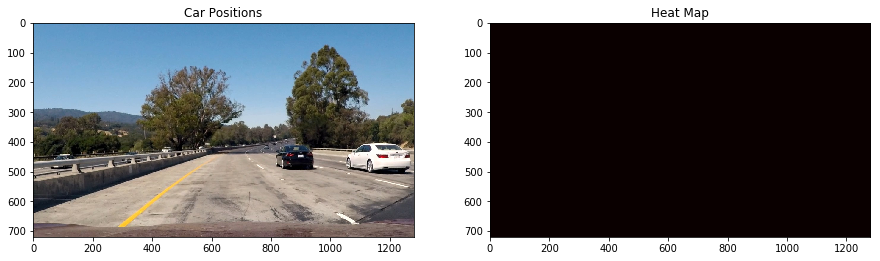

In [170]:
heat_historical = np.zeros((h,w,5)).astype(np.float)
draw_img, heatmap = add_heat_box(image, hot_windows)
multiplot([draw_img, heatmap], ['Car Positions', 'Heat Map'], (1,2), cmap='hot')

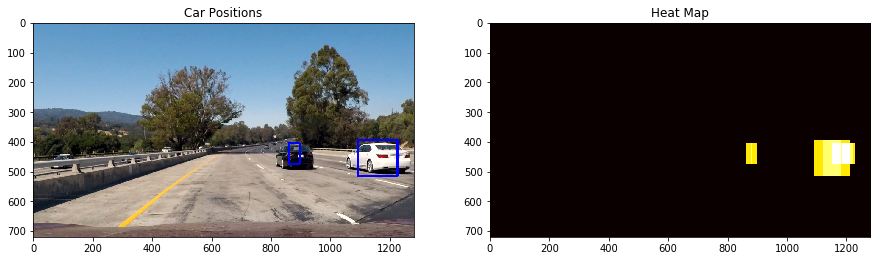

In [171]:
draw_img, heatmap = add_heat_box(image, hot_windows)
multiplot([draw_img, heatmap], ['Car Positions', 'Heat Map'], (1,2), cmap='hot')

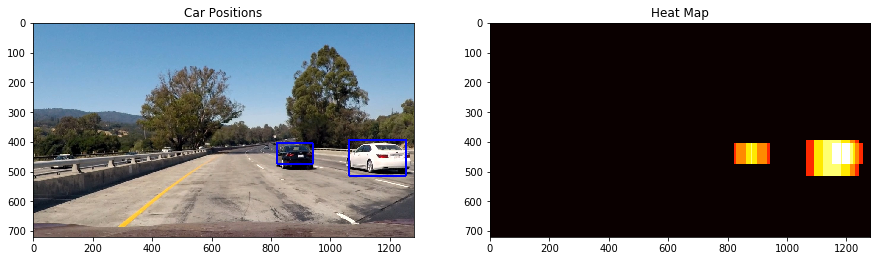

In [172]:
draw_img, heatmap = add_heat_box(image, hot_windows)
multiplot([draw_img, heatmap], ['Car Positions', 'Heat Map'], (1,2), cmap='hot')

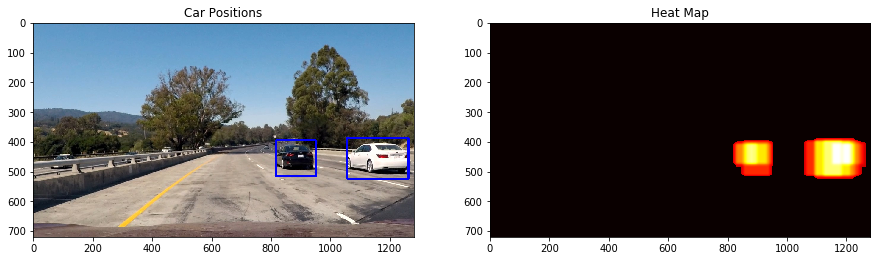

In [25]:
heat_historical = np.zeros((h,w,5)).astype(np.float)
draw_img, heatmap = add_heat_box(image, hot_windows)
multiplot([draw_img, heatmap], ['Car Positions', 'Heat Map'], (1,2), cmap='hot')

## Video pipeline

In [21]:
def image_process(image):
    global windows, svc, X_scaler, color_space, spatial_size, hist_bins, orient
    global pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
    result = add_heat_box(image, hot_windows, threshold = 2)
    return result[0]

In [26]:
heat_historical = np.zeros((h,w,5)).astype(np.float)
name_output = 'test_video_processed.mp4'
clip = VideoFileClip("test_video.mp4")
output = clip.fl_image(image_process)
%time output.write_videofile(name_output, audio=False)

[MoviePy] >>>> Building video test_video_processed.mp4
[MoviePy] Writing video test_video_processed.mp4



 97%|█████████▋| 38/39 [01:02<00:01,  1.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_processed.mp4 

CPU times: user 54.8 s, sys: 2.65 s, total: 57.4 s
Wall time: 1min 4s


In [ ]:
heat_historical = np.zeros((h,w,5)).astype(np.float)
name_output = 'project_video_processed.mp4'
clip = VideoFileClip("project_video.mp4")
output = clip.fl_image(image_process)
%time output.write_videofile(name_output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4



  6%|▌         | 76/1261 [02:00<35:55,  1.82s/it]

## Faster HOG strategy

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left, ytop_draw, win_draw = np.int(xleft*scale), np.int(ytop*scale), np.int(window*scale)
                box_list.append([(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    
    draw_img = draw_boxes(img, box_list)       
                
    return draw_img, box_list
    
scale = 1.5
y_start = y_start_stop[0]
y_stop = y_start_stop[1]
    
out_img, box_list = find_cars(image, y_start, y_stop, scale, svc,
                    X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()